<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Libraries" data-toc-modified-id="Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Libraries</a></span></li><li><span><a href="#Split-Train/Test/Validation" data-toc-modified-id="Split-Train/Test/Validation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Split Train/Test/Validation</a></span></li><li><span><a href="#Baseline-model" data-toc-modified-id="Baseline-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Baseline model</a></span></li><li><span><a href="#Models-Training" data-toc-modified-id="Models-Training-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Models Training</a></span><ul class="toc-item"><li><span><a href="#Light-Gradient-Boosting-Machine-(LGBM)" data-toc-modified-id="Light-Gradient-Boosting-Machine-(LGBM)-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Light Gradient Boosting Machine (LGBM)</a></span></li></ul></li></ul></div>

# Libraries

In [69]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Split Train/Test/Validation

In [70]:
data = pd.read_csv('data/eda_dataset_imputed.csv')

app_train, test_1 = train_test_split(data, test_size=0.30, random_state=64)
app_test, app_validation = train_test_split(test_1, test_size=0.5, random_state=56)

In [71]:
app_train.shape, app_test.shape, app_validation.shape

((215257, 450), (46127, 450), (46127, 450))

# Baseline model

In [72]:
train_labels = app_train['TARGET']
test_labels = app_test['TARGET']

In [73]:
from sklearn.preprocessing import MinMaxScaler, Imputer

# Drop the target from the training data
if 'TARGET' in app_train:
    train = app_train.drop(['TARGET'], axis=1)
else:
    train = app_train.copy()

    
if 'TARGET' in app_test:
    test = app_test.drop(['TARGET'], axis=1)
else:
    test = app_test.copy()

if 'TARGET' in app_validation:
    validation = app_validation.drop(['TARGET'], axis=1)
else:
    validation = app_validation.copy()
    
    
# Feature names
features = list(train.columns)

# Median imputation of missing values
imputer = Imputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(test)
validation = imputer.transform(validation)

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)
validation = scaler.transform(validation)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)
print('Validation data shape: ', validation.shape)

Training data shape:  (215257, 449)
Testing data shape:  (46127, 449)
Testing data shape:  (46127, 449)


In [74]:
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg.fit(train, train_labels)

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [75]:
# Make predictions
# Make sure to select the second column only
log_reg_pred = log_reg.predict_proba(test)[:, 1]

In [76]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_error

print("ROC AUC: ", roc_auc_score(test_labels, log_reg_pred))
print("MAE: ", mean_absolute_error(test_labels, log_reg_pred))

ROC AUC:  0.713790323186
MAE:  0.149072307289


# Models Training

## Light Gradient Boosting Machine (LGBM)

In [99]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, mean_absolute_error
import lightgbm as lgb
from sklearn.utils.multiclass import type_of_target

import gc

def modelLGBM(features, test_features, lgbm_params, validation_features=None, n_folds = 5): 
    """Train, test and validation a light gradient boosting model using cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        
    Return
    --------
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    if validation_features is not None:
        validation_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = np.array(features['TARGET'].astype(int))
    test_labels = np.array(test_features['TARGET'].astype(int))
    if validation_features is not None:
        validation_labels = np.array(validation_features['TARGET'].astype(int))
    
    # Remove the ids and target
    features = features.drop(['SK_ID_CURR', 'TARGET'], axis=1)
    test_features = test_features.drop(['SK_ID_CURR', 'TARGET'], axis=1)
    if validation_features is not None:
        validation_features = validation_features.drop(['SK_ID_CURR', 'TARGET'], axis=1)
    
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    if validation_features is not None:
        print('Validation Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    if validation_features is not None:
        validation_features = np.array(validation_features)
        
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    if validation_features is not None:
        validation_predictions = np.zeros(validation_features.shape[0])
        
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores_auc = []
    train_scores_auc = []
    valid_scores_mae = []
    train_scores_mae = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(application="binary", boosting_type=lgbm_params["boosting"],
                          learning_rate=lgbm_params["learning_rate"],n_estimators=lgbm_params["n_estimators"],
                          reg_alpha = lgbm_params["reg_alpha"], reg_lambda = lgbm_params["reg_lambda"], 
                          drop_rate=lgbm_params["drop_rate"],
                          num_leaves=lgbm_params["num_leaves"], max_depth=lgbm_params["max_depth"],
                          max_bin=lgbm_params["max_bin"],
                          subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = ['auc', 'mae'],
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'],
                  early_stopping_rounds = lgbm_params["early_stopping_rounds"], verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        if validation_features is not None:
            validation_predictions += model.predict_proba(validation_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
            
        # Record the best score
        valid_score_auc = model.best_score_['valid']['auc']
        train_score_auc = model.best_score_['train']['auc']
        valid_score_mae = model.best_score_['valid']['l1']
        train_score_mae = model.best_score_['train']['l1']
        
        valid_scores_auc.append(valid_score_auc)
        train_scores_auc.append(train_score_auc)
        valid_scores_mae.append(valid_score_mae)
        train_scores_mae.append(train_score_mae)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(test_labels, test_predictions)
    valid_mae = mean_absolute_error(test_labels, test_predictions)
    if validation_features is not None:
        validation_auc = roc_auc_score(validation_labels, validation_predictions)
        validation_mae = mean_absolute_error(validation_labels, validation_predictions)
    
    # Add the overall scores to the metrics
    valid_scores_auc.append(valid_auc)
    train_scores_auc.append(np.mean(train_scores_auc))
    valid_scores_mae.append(valid_mae)
    train_scores_mae.append(np.mean(train_scores_mae))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train auc': train_scores_auc,
                            'valid auc': valid_scores_auc,
                            'train mae': train_scores_mae,
                            'valid mae': valid_scores_mae}) 

    if validation_features is not None:
        validation_metrics = pd.DataFrame({'auc': [validation_auc],
                                           'mae': [validation_mae]}) 
    else:
        validation_metrics = None
        

    return feature_importances, metrics, validation_metrics

In [78]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

Training Data Shape:  (215257, 448)
Testing Data Shape:  (46127, 448)
Validation Data Shape:  (46127, 448)
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[1]	valid's l1: 0.147311	valid's auc: 0.723401	train's l1: 0.14792	train's auc: 0.7318
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[1]	valid's l1: 0.148166	valid's auc: 0.713849	train's l1: 0.147331	train's auc: 0.733773
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[1]	valid's l1: 0.146675	valid's auc: 0.710136	train's l1: 0.148293	train's auc: 0.736016
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[1]	valid's l1: 0.147919	valid's auc: 0.720005	train's l1: 0.147496	train's auc: 0.733249
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. 

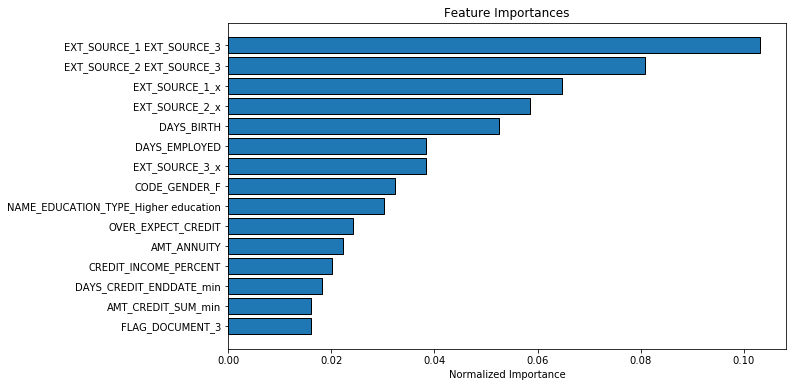

        auc       mae
0  0.724932  0.148637


In [100]:
lgbm_params = {
    "boosting":"dart",
    "application":"binary",
    "learning_rate": 0.1,
    'reg_alpha':0.01,
    'reg_lambda': 0.01,
    "n_estimators":10000,
    "max_depth":7,
    "num_leaves":100,
    "max_bin":225,
    "drop_rate":0.02,
    "early_stopping_rounds": 200
}

fi, metrics, validation_metrics = modelLGBM(app_train, app_test, lgbm_params=lgbm_params)
print('Baseline metrics')
print(metrics)
fi_sorted = plot_feature_importances(fi)

Training Data Shape:  (215257, 448)
Testing Data Shape:  (46127, 448)
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.133782	valid's auc: 0.7506	train's l1: 0.120064	train's auc: 0.912934
Early stopping, best iteration is:
[86]	valid's l1: 0.135583	valid's auc: 0.754204	train's l1: 0.128797	train's auc: 0.857283
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134541	valid's auc: 0.748257	train's l1: 0.119671	train's auc: 0.911534
Early stopping, best iteration is:
[97]	valid's l1: 0.13609	valid's auc: 0.750568	train's l1: 0.127534	train's auc: 0.864312
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.133348	valid's auc: 0.739781	train's l1: 0.120461	train's auc: 0.909081
Early stopping, best iteration is:
[98]	valid's l1: 0.134877	valid's auc: 0.741182	train's l1: 0.127649	train's auc: 0.865789
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.134689	

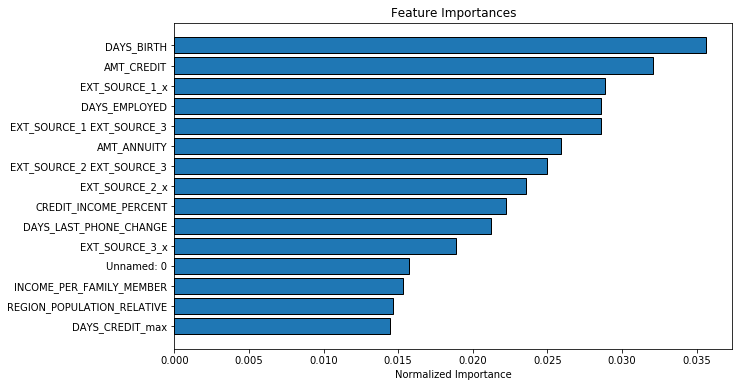

In [80]:
lgbm_params = {
    "boosting":"gbdt",
    "application":"binary",
    "learning_rate": 0.1,
    'reg_alpha':0.1,
    'reg_lambda': 0.1,
    "n_estimators":10000,
    "max_depth":7,
    "num_leaves":200,
    "max_bin":225,
    "drop_rate":0.02,
    "early_stopping_rounds": 200
}

fi, metrics = modelLGBM(app_train, app_test, lgbm_params=lgbm_params)
print('Baseline metrics')
print(metrics)
fi_sorted = plot_feature_importances(fi)

Training Data Shape:  (215257, 448)
Testing Data Shape:  (46127, 448)
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135621	valid's auc: 0.755764	train's l1: 0.131104	train's auc: 0.828261
Early stopping, best iteration is:
[134]	valid's l1: 0.135961	valid's auc: 0.756757	train's l1: 0.133003	train's auc: 0.809402
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.136436	valid's auc: 0.751696	train's l1: 0.130652	train's auc: 0.828086
Early stopping, best iteration is:
[104]	valid's l1: 0.13708	valid's auc: 0.752171	train's l1: 0.133561	train's auc: 0.800085
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135294	valid's auc: 0.74148	train's l1: 0.131054	train's auc: 0.829337
Early stopping, best iteration is:
[157]	valid's l1: 0.135511	valid's auc: 0.742536	train's l1: 0.132307	train's auc: 0.817467
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.136

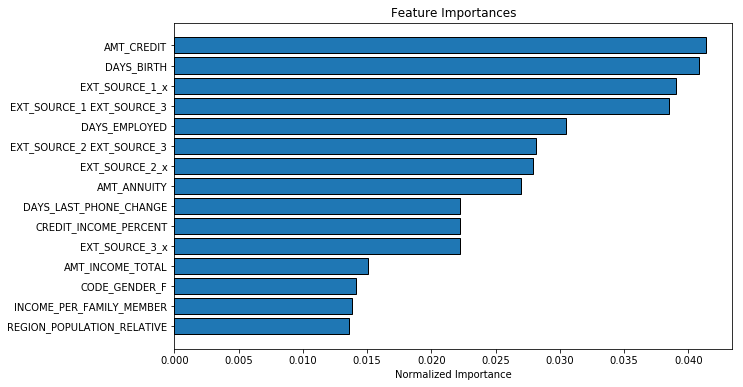

In [81]:
lgbm_params = {
    "boosting":"gbdt",
    "application":"binary",
    "learning_rate": 0.1,
    'reg_alpha':0.1,
    'reg_lambda': 0.1,
    "n_estimators":10000,
    "max_depth":5,
    "num_leaves":200,
    "max_bin":225,
    "drop_rate":0.02,
    "early_stopping_rounds": 200
}

fi, metrics = modelLGBM(app_train, app_test, lgbm_params=lgbm_params)
print('Baseline metrics')
print(metrics)
fi_sorted = plot_feature_importances(fi)

In [82]:
lgbm_params = {
    "boosting":"gbdt",
    "application":"binary",
    "learning_rate": 0.1,
    'reg_alpha':10,
    'reg_lambda': 10,
    "n_estimators":10000,
    "max_depth":5,
    "num_leaves":200,
    "max_bin":225,
    "drop_rate":0.02,
    "early_stopping_rounds": 200
}

fi, metrics = modelLGBM(app_train, app_test, lgbm_params=lgbm_params)
print('Baseline metrics')
print(metrics)
fi_sorted = plot_feature_importances(fi)

Training Data Shape:  (215257, 448)
Testing Data Shape:  (46127, 448)
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.135633	valid's auc: 0.7586	train's l1: 0.132768	train's auc: 0.805001
Early stopping, best iteration is:
[199]	valid's l1: 0.135634	valid's auc: 0.758607	train's l1: 0.132783	train's auc: 0.804923
Training until validation scores don't improve for 200 rounds.
[200]	valid's l1: 0.136347	valid's auc: 0.754799	train's l1: 0.132395	train's auc: 0.805111
[400]	valid's l1: 0.135693	valid's auc: 0.753615	train's l1: 0.128439	train's auc: 0.843778
Early stopping, best iteration is:
[224]	valid's l1: 0.136259	valid's auc: 0.755165	train's l1: 0.131917	train's auc: 0.810282
Training until validation scores don't improve for 200 rounds.


KeyboardInterrupt: 

In [ ]:
lgbm_params = {
    "boosting":"gbdt",
    "application":"binary",
    "learning_rate": 0.1,
    'reg_alpha':100,
    'reg_lambda': 100,
    "n_estimators":10000,
    "max_depth":5,
    "num_leaves":200,
    "max_bin":225,
    "drop_rate":0.02,
    "early_stopping_rounds": 200
}

fi, metrics = modelLGBM(app_train, app_test, lgbm_params=lgbm_params)
print('Baseline metrics')
print(metrics)
fi_sorted = plot_feature_importances(fi)

In [ ]:
lgbm_params = {
    "boosting":"gbdt",
    "application":"binary",
    "learning_rate": 0.01,
    'reg_alpha':10,
    'reg_lambda': 10,
    "n_estimators":10000,
    "max_depth":5,
    "num_leaves":200,
    "max_bin":225,
    "drop_rate":0.02,
    "early_stopping_rounds": 500
}

fi, metrics = modelLGBM(app_train, app_test, lgbm_params=lgbm_params, validation_features=app_validation)
print('Baseline metrics')
print(metrics)
fi_sorted = plot_feature_importances(fi)
print(validation_metrics)

## XGBoost

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, mean_absolute_error
import xgboost as xgb

import gc

def modelXGBoost(features, test_features, params, n_folds = 5): 
    """Train and test a XGBoost model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        
    Return
    --------
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = np.array(features['TARGET'].astype(int))
    
    # Remove the ids and target
    features = features.drop(['SK_ID_CURR', 'TARGET'], axis=1)
    test_features = test_features.drop(['SK_ID_CURR', 'TARGET'], axis=1)
    
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores_auc = []
    train_scores_auc = []
    valid_scores_mae = []
    train_scores_mae = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = xgb.XGBClassifier(learning_rate =params["learning_rate"], 
                                  n_estimators=params["n_estimators"], 
                                  max_depth=params["max_depth"], 
                                  min_child_weight=params["min_child_weight"], 
                                  subsample=params["subsample"], 
                                  colsample_bytree=params["colsample_bytree"], 
                                  objective= 'binary:logistic', 
                                  nthread=4, 
                                  scale_pos_weight=2, 
                                  seed=27)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = ['mae', 'auc'],
                  eval_set = [(train_features, train_labels), (valid_features, valid_labels)],
                  #eval_names = ['valid', 'train'],
                  early_stopping_rounds = params["early_stopping_rounds"], verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        #test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        test_predictions += model.predict_proba(test_features)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features)[:, 1]
        
        # Record the best score
        valid_score_auc = model.evals_result()['validation_1']['auc'][best_iteration] #model.best_score_['valid']['auc']
        train_score_auc = model.evals_result()['validation_0']['auc'][best_iteration] #model.best_score_['train']['auc']
        valid_score_mae = model.evals_result()['validation_1']['mae'][best_iteration] #model.best_score_['valid']['auc']
        train_score_mae = model.evals_result()['validation_0']['mae'][best_iteration] #model.best_score_['train']['auc']
        
        valid_scores_auc.append(valid_score_auc)
        train_scores_auc.append(train_score_auc)
        valid_scores_mae.append(valid_score_mae)
        train_scores_mae.append(train_score_mae)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    valid_mae = mean_absolute_error(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores_auc.append(valid_auc)
    train_scores_auc.append(np.mean(train_scores_auc))
    valid_scores_mae.append(valid_mae)
    train_scores_mae.append(np.mean(train_scores_mae))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train auc': train_scores_auc,
                            'valid auc': valid_scores_auc,
                            'train mae': train_scores_mae,
                            'valid mae': valid_scores_mae}) 
    
    return feature_importances, metrics

In [ ]:
params = {
    "learning_rate": 0.1,
    "n_estimators":10000,
    "max_depth":7,
    "min_child_weight": 4,
    "subsample": 0.8, 
    "colsample_bytree": 0.8,
    "early_stopping_rounds": 200
}

fi, metrics = modelXGBoost(app_train, app_test, params=params)
print('Baseline metrics')
print(metrics)
fi_sorted = plot_feature_importances(fi)

In [ ]:
params = {
    "learning_rate": 0.1,
    "n_estimators": 10000,
    "max_depth":5,
    "min_child_weight": 40,
    "subsample": 0.7, 
    "colsample_bytree": 0.8,
    "early_stopping_rounds": 200
}

fi, metrics = modelXGBoost(app_train, app_test, params=params)
print('Baseline metrics')
print(metrics)
fi_sorted = plot_feature_importances(fi)

In [ ]:
params = {
    "learning_rate": 0.1,
    "n_estimators": 10000,
    "max_depth":5,
    "min_child_weight": 40,
    "subsample": 0.7, 
    "colsample_bytree": 0.6,
    "early_stopping_rounds": 200
}

fi, metrics = modelXGBoost(app_train, app_test, params=params)
print('Baseline metrics')
print(metrics)
fi_sorted = plot_feature_importances(fi)

In [ ]:
params = {
    "learning_rate": 0.1,
    "n_estimators": 10000,
    "max_depth":3,
    "min_child_weight": 40,
    "subsample": 0.7, 
    "colsample_bytree": 0.8,
    "early_stopping_rounds": 200
}

fi, metrics = modelXGBoost(app_train, app_test, params=params)
print('Baseline metrics')
print(metrics)
fi_sorted = plot_feature_importances(fi)

In [ ]:
params = {
    "learning_rate": 0.01,
    "n_estimators": 10000,
    "max_depth":5,
    "min_child_weight": 40,
    "subsample": 0.7, 
    "colsample_bytree": 0.6,
    "early_stopping_rounds": 500
}

fi, metrics = modelXGBoost(app_train, app_test, params=params)
print('Baseline metrics')
print(metrics)
fi_sorted = plot_feature_importances(fi)

### Random Forest

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, mean_absolute_error
from sklearn.ensemble import RandomForestClassifier

import gc

def modelRandomForest(features, test_features, params, n_folds = 5): 
    """Train and test a Random Forest model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        
    Return
    --------
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = np.array(features['TARGET'].astype(int))
    
    # Remove the ids and target
    features = features.drop(['SK_ID_CURR', 'TARGET'], axis=1)
    test_features = test_features.drop(['SK_ID_CURR', 'TARGET'], axis=1)
    
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores_auc = []
    train_scores_auc = []
    valid_scores_mae = []
    train_scores_mae = []
    
    # Iterate through each fold
    i = 0
    for train_indices, valid_indices in k_fold.split(features):
        i+=1
        print("Training model", i)
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = RandomForestClassifier(bootstrap=True, 
                                       class_weight="balanced", 
                                       criterion=params["criterion"]'gini',
                                       max_depth=params["max_depth"], 
                                       max_features=params["max_features"], 
                                       #max_leaf_nodes=None,
                                       #min_impurity_decrease=0.0, 
                                       #min_impurity_split=None,
                                       min_samples_leaf=params["min_samples_leaf"], 
                                       #min_samples_split=2,
                                       #min_weight_fraction_leaf=0.0,
                                       n_estimators=params["n_estimators"], 
                                       n_jobs=5,
                                       #oob_score=False, 
                                       random_state=562, 
                                       verbose=1,
                                       warm_start=False)
        
        # Train the model
        model.fit(train_features, train_labels)
        
        # Record the best iteration
        # best_iteration = model.best_iteration
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        #test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        test_predictions += model.predict_proba(test_features)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features)[:, 1]
        
        t_p = model.predict_proba(train_features)[:, 1]
        v_p = model.predict_proba(valid_features)[:, 1]
        
        # Record the best score
        valid_score_auc = roc_auc_score(valid_labels, v_p)
        train_score_auc = roc_auc_score(train_labels, t_p)
        valid_score_mae = mean_absolute_error(valid_labels, v_p)
        train_score_mae = mean_absolute_error(train_labels, t_p)
        
        valid_scores_auc.append(valid_score_auc)
        train_scores_auc.append(train_score_auc)
        valid_scores_mae.append(valid_score_mae)
        train_scores_mae.append(train_score_mae)
        
        print("valid's mae: ", valid_score_mae,"	valid's auc: ", valid_score_auc, "	train's mae: ", train_score_mae, "	train's auc: ", train_score_auc)
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    valid_mae = mean_absolute_error(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores_auc.append(valid_auc)
    train_scores_auc.append(np.mean(train_scores_auc))
    valid_scores_mae.append(valid_mae)
    train_scores_mae.append(np.mean(train_scores_mae))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train auc': train_scores_auc,
                            'valid auc': valid_scores_auc,
                            'train mae': train_scores_mae,
                            'valid mae': valid_scores_mae}) 
    
    return feature_importances, metrics

In [ ]:
params = {
    "criterion": 'gini',
    "n_estimators":100,
    "max_features": 0.5,
    "max_depth":7,
    "min_samples_leaf": 4
}

fi, metrics = modelRandomForest(app_train, app_test, params=params)
print('Baseline metrics')
print(metrics)
fi_sorted = plot_feature_importances(fi)

In [ ]:
params = {
    "criterion": 'gini',
    "n_estimators":100,
    "max_features": 0.8,
    "max_depth":5,
    "min_samples_leaf": 4
}

fi, metrics = modelRandomForest(app_train, app_test, params=params)
print('Baseline metrics')
print(metrics)
fi_sorted = plot_feature_importances(fi)

In [ ]:
params = {
    "criterion": 'gini',
    "n_estimators":100,
    "max_features": 0.3,
    "max_depth":14,
    "min_samples_leaf": 4
}

fi, metrics = modelRandomForest(app_train, app_test, params=params)
print('Baseline metrics')
print(metrics)
fi_sorted = plot_feature_importances(fi)

In [ ]:
params = {
    "criterion": 'gini',
    "n_estimators":100,
    "max_features": 0.8,
    "max_depth":14,
    "min_samples_leaf": 0.001
}

fi, metrics = modelRandomForest(app_train, app_test, params=params)
print('Baseline metrics')
print(metrics)
fi_sorted = plot_feature_importances(fi)

In [ ]:
params = {
    "criterion": 'gini',
    "n_estimators":100,
    "max_features": 0.8,
    "max_depth":28,
    "min_samples_leaf": 0.001
}

fi, metrics = modelRandomForest(app_train, app_test, params=params)
print('Baseline metrics')
print(metrics)
fi_sorted = plot_feature_importances(fi)

In [ ]:
params = {
    "criterion": 'entropy',
    "n_estimators":100,
    "max_features": 0.8,
    "max_depth":14,
    "min_samples_leaf": 0.001
}

fi, metrics = modelRandomForest(app_train, app_test, params=params)
print('Baseline metrics')
print(metrics)
fi_sorted = plot_feature_importances(fi)

In [ ]:
params = {
    "criterion": 'gini',
    "n_estimators":1000,
    "max_features": 0.8,
    "max_depth":14,
    "min_samples_leaf": 0.001
}

fi, metrics = modelRandomForest(app_train, app_test, params=params)
print('Baseline metrics')
print(metrics)
fi_sorted = plot_feature_importances(fi)